## Задача

1.      По наиболее актуальным данным Росстата о ключевых показателях мониторинга развития регионов сегментировать территории и описать полученные кластеры бизнес-языком. 
2.      Предполагая, что губернаторы регионов не менялись на протяжении всех периодов в выборке, составить список территорий для увольнения губернаторов с коротким обоснованием принципов формирования. 
3.      На основе задачи 2 придумать автоматический алгоритм увольнения губернаторов и описать критерии и правила увольнений
 
Для кластеризации можно применять любые инструменты Excel, Python, R и т.д. инструменты и методологию лучше выбрать по соотношению Трудозатраты/эффект.
На выходе мы ждем Эксель/код с описанием в ворде. 
 
Dataset
<https://gks.ru/free_doc/new_site/rosstat/pok-monitor/pok-monitor.html>

## Загрузка библиотек и датасетов, первичная предобработка

### Библиотеки

In [1]:
#импортируем библиотеки

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display
from functools import reduce

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#from plotly import graph_objects as go

### Реальная  среднемесячная начисленная заработная плата работников организаций по субъектам Российской Федерации

In [2]:
avg_salary = pd.read_excel('C:\\anaconda3\\Test\\avg_salary.xlsx', sheet_name='list1')
avg_salary.info()
display(avg_salary.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  98 non-null     object
 1   Unnamed: 1  97 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


,Unnamed: 0,Unnamed: 1
0,Реальная среднемесячная начисленная заработна...,NaN
1,NaN,NaN
2,Наименование,2020 г. в % к 2019 г.
3,Российская Федерация,102.5
4,Центральный федеральный округ,103.4
5,Белгородская область,104.5
6,Брянская область,102.2
7,Владимирская область,102.4


In [3]:
#обновим названия колонок

avg_salary.columns = ['region','salary_percent_yty']

In [4]:
#дропнем артефакты

avg_salary = avg_salary.drop(avg_salary.index[:3])

In [5]:
#изменим тип данных 

avg_salary['salary_percent_yty'] = avg_salary['salary_percent_yty'].astype('float')

In [6]:
#селф-чекинг

avg_salary.head()

,region,salary_percent_yty
3,Российская Федерация,102.5
4,Центральный федеральный округ,103.4
5,Белгородская область,104.5
6,Брянская область,102.2
7,Владимирская область,102.4


### Объем жилищного строительства в 2020 году 

In [7]:
building_volume = pd.read_excel('C:\\anaconda3\\Test\\building_volume.xls', sheet_name='list1')
building_volume.info()
display(building_volume.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype 
---  ------                                      --------------  ----- 
 0   Объем жилищного строительства в 2020 году   97 non-null     object
 1   Unnamed: 1                                  97 non-null     object
 2   Unnamed: 2                                  98 non-null     object
 3   Unnamed: 3                                  97 non-null     object
dtypes: object(4)
memory usage: 3.3+ KB


,Объем жилищного строительства в 2020 году,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,тысяч квадратных метров общей площади жилых по...,NaN,NaN,NaN
1,NaN,"Объем жилищного строительства, всего, млн",в том числе :,NaN
2,NaN,NaN,ввод жилья в МКД,"ввод жилья, построенного населением"
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,Российская Федерация,82.1845,42.3827,39.8018
6,Центральный федеральный округ,25.5333,13.4799,12.0534
7,Белгородская область,1.1486,0.2136,0.935


In [8]:
#обновим названия колонок

building_volume.columns = ['region','total', 'building_vol_mkd', 'building_vol_cit']

In [9]:
#столбец с суммой не требуется

building_volume = building_volume.drop(columns = ['total'])

In [10]:
#дропнем артефакты

building_volume = building_volume.drop(building_volume.index[:5])

In [11]:
#селф-чекинг

building_volume.head()

,region,building_vol_mkd,building_vol_cit
5,Российская Федерация,42.3827,39.8018
6,Центральный федеральный округ,13.4799,12.0534
7,Белгородская область,0.2136,0.935
8,Брянская область,0.2515,0.1752
9,Владимирская область,0.2454,0.4809


### Предварительная оценка ожидаемой продолжительности жизни при рождении по субъектам Российской Федерации за 2020 год

In [12]:
lifetime_exp = pd.read_excel('C:\\anaconda3\\Test\\lifetime_exp.xlsx', sheet_name='list1')
lifetime_exp.info()
display(lifetime_exp.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 2 columns):
 #   Column                                                                                                                Non-Null Count  Dtype 
---  ------                                                                                                                --------------  ----- 
 0   Предварительная оценка ожидаемой продолжительности жизни при рождении 
по субъектам Российской Федерации за 2020 год  96 non-null     object
 1   Unnamed: 1                                                                                                            97 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


,Предварительная оценка ожидаемой продолжительности жизни при рождении \nпо субъектам Российской Федерации за 2020 год,Unnamed: 1
0,NaN,NaN
1,NaN,Число\nлет
2,Российская Федерация,71.5
3,Центральный федеральный округ,72.6
4,Белгородская область,72.4
5,Брянская область,70.6
6,Владимирская область,70
7,Воронежская область,71.9


In [13]:
#обновим названия колонок

lifetime_exp.columns = ['region','lifetime_exp']

In [14]:
#дропнем артефакты

lifetime_exp = lifetime_exp.drop(lifetime_exp.index[:2])

In [15]:
#изменим тип данных 

lifetime_exp['lifetime_exp'] = lifetime_exp['lifetime_exp'].astype('float')

In [16]:
#селф-чекинг

lifetime_exp.head()

,region,lifetime_exp
2,Российская Федерация,71.5
3,Центральный федеральный округ,72.6
4,Белгородская область,72.4
5,Брянская область,70.6
6,Владимирская область,70.0


### Оценка численности постоянного населения на 1 января 2021 года

In [17]:
pop_count = pd.read_excel('C:\\anaconda3\\Test\\pop_count.xls', sheet_name='list1')
pop_count.info()
display(pop_count.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  98 non-null     object
 1   Unnamed: 1  97 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


,Unnamed: 0,Unnamed: 1
0,ОЦЕНКА ЧИСЛЕННОСТИ ПОСТОЯННОГО НАСЕЛЕНИЯ на 1 ...,NaN
1,(человек),NaN
2,NaN,NaN
3,NaN,Все население
4,Российская Федеpация,146171015
5,Центральный федеральный округ,39250960
6,Белгородская область,1541259
7,Брянская область,1182682


In [18]:
#обновим названия колонок

pop_count.columns = ['region','pop_count']

In [19]:
#дропнем артефакты

pop_count = pop_count.drop(pop_count.index[:4])

In [20]:
#изменим тип данных 

pop_count['pop_count'] = pop_count['pop_count'].astype('int')

In [21]:
#селф-чекинг

pop_count.head()

,region,pop_count
4,Российская Федеpация,146171015
5,Центральный федеральный округ,39250960
6,Белгородская область,1541259
7,Брянская область,1182682
8,Владимирская область,1342099


### Уровень бедности: доля численности населения с денежными доходами ниже величины прожиточного минимума в процентах к общей численности населения

In [22]:
poverty_rate = pd.read_excel('C:\\anaconda3\\Test\\poverty_rate.xlsx', sheet_name='list1')
poverty_rate.info()
display(poverty_rate.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   2.1.7 Уровень бедности 1)  100 non-null    object 
 1   Unnamed: 1                 89 non-null     float64
 2   Unnamed: 2                 89 non-null     object 
 3   Unnamed: 3                 89 non-null     object 
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


,2.1.7 Уровень бедности 1),Unnamed: 1,Unnamed: 2,Unnamed: 3
0,(доля численности населения с денежными дохода...,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,2018.0,20192),20203)
3,Российская Федерация,12.6,12.3,12.1
4,Центральный федеральный округ,NaN,NaN,NaN
5,Белгородская область,7.5,7.8,7.2
6,Брянская область,13.6,13.8,13.8
7,Владимирская область,13.1,12.6,12.5


In [23]:
#обновим названия колонок

poverty_rate.columns = ['region','poverty18', 'poverty19', 'poverty20']

In [24]:
#дропнем артефакты

poverty_rate = poverty_rate.drop(poverty_rate.index[:3])
poverty_rate.drop(poverty_rate.tail(3).index, inplace = True)

In [25]:
#дропнем архивные данные за 18 и 19 годы - они зашумляют дальнейший анализ

poverty_rate = poverty_rate.drop(columns = ['poverty18', 'poverty19'])

In [26]:
#изменим тип данных 

poverty_rate['poverty20'] = poverty_rate['poverty20'].astype('float')

In [27]:
#селф-чекинг

poverty_rate.head()

,region,poverty20
3,Российская Федерация,12.1
4,Центральный федеральный округ,NaN
5,Белгородская область,7.2
6,Брянская область,13.8
7,Владимирская область,12.5


### Темп роста (индекс роста) реального среднедушевого денежного дохода населения в 2020 г. (первая оценка - на 34 рабочий день)

In [28]:
sal_growth_index = pd.read_excel('C:\\anaconda3\\Test\\sal_growth_index.xlsx', sheet_name='list1')
sal_growth_index.info()
display(sal_growth_index.head(8))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Темп роста (индекс роста) реального среднедушевого   98 non-null     object
 1   Unnamed: 1                                           98 non-null     object
dtypes: object(2)
memory usage: 1.7+ KB


,Темп роста (индекс роста) реального среднедушевого,Unnamed: 1
0,денежного дохода населения в 2020 г. (первая о...,NaN
1,NaN,NaN
2,в % к предыдущему году,NaN
3,NaN,Темп роста (индекс роста) реального среднедуше...
4,NaN,денежного дохода населения в 2020 г. (первая о...
5,Российская Федерация,97
6,Центральный федеральный округ,97.5
7,Белгородская область,98.4


In [29]:
#обновим названия колонок

sal_growth_index.columns = ['region', 'sal_growth_index']

In [30]:
#дропнем артефакты

sal_growth_index = sal_growth_index.drop(sal_growth_index.index[:5])

In [31]:
#изменим тип данных 

sal_growth_index['sal_growth_index'] = sal_growth_index['sal_growth_index'].astype('float')

In [32]:
#селф-чекинг

sal_growth_index.head()

,region,sal_growth_index
5,Российская Федерация,97.0
6,Центральный федеральный округ,97.5
7,Белгородская область,98.4
8,Брянская область,95.8
9,Владимирская область,98.1


## Проверка на дубликаты, аномалии и пропуски

### Проверка на пропуски

In [33]:
avg_salary_columns = ['region','salary_percent_yty']

def avg_salary_count_nan(list):
    
    for file in avg_salary_columns:
        print('- Пропусков в датасете avg_salary/ {}:'.format(file), len(avg_salary[avg_salary[file].isna()]))
        
avg_salary_count_nan(avg_salary_columns)

- Пропусков в датасете avg_salary/ region: 0
- Пропусков в датасете avg_salary/ salary_percent_yty: 0


In [34]:
building_volume_columns = ['region','building_vol_mkd', 'building_vol_cit']

def building_volume_count_nan(list):
    
    for file in building_volume_columns:
        print('- Пропусков в датасете building_volume/ {}:'.format(file), len(building_volume[building_volume[file].isna()]))
        
building_volume_count_nan(building_volume_columns)

- Пропусков в датасете building_volume/ region: 0
- Пропусков в датасете building_volume/ building_vol_mkd: 0
- Пропусков в датасете building_volume/ building_vol_cit: 0


In [35]:
lifetime_exp_columns = ['region','lifetime_exp']

def lifetime_exp_count_nan(list):
    
    for file in lifetime_exp_columns:
        print('- Пропусков в датасете lifetime_exp/ {}:'.format(file), len(lifetime_exp[lifetime_exp[file].isna()]))
        
lifetime_exp_count_nan(lifetime_exp_columns)

- Пропусков в датасете lifetime_exp/ region: 0
- Пропусков в датасете lifetime_exp/ lifetime_exp: 0


In [36]:
pop_count_columns = ['region','pop_count']

def pop_count_count_nan(list):
    
    for file in pop_count_columns:
        print('- Пропусков в датасете pop_count/ {}:'.format(file), len(pop_count[pop_count[file].isna()]))
        
pop_count_count_nan(pop_count_columns)

- Пропусков в датасете pop_count/ region: 0
- Пропусков в датасете pop_count/ pop_count: 0


In [37]:
poverty_rate_columns = ['region', 'poverty20']

def poverty_rate_count_nan(list):
    
    for file in poverty_rate_columns:
        print('- Пропусков в датасете poverty_rate/ {}:'.format(file), len(poverty_rate[poverty_rate[file].isna()]))
        
poverty_rate_count_nan(poverty_rate_columns)

- Пропусков в датасете poverty_rate/ region: 0
- Пропусков в датасете poverty_rate/ poverty20: 8


Недостаточно данных, чтобы должным образом заполнить пропуски. Оставим без изменений. 

In [38]:
sal_growth_index_columns = ['region', 'sal_growth_index']

def sal_growth_index_count_nan(list):
    
    for file in sal_growth_index_columns:
        print('- Пропусков в датасете sal_growth_index/ {}:'.format(file), len(sal_growth_index[sal_growth_index[file].isna()]))
        
sal_growth_index_count_nan(sal_growth_index_columns)

- Пропусков в датасете sal_growth_index/ region: 0
- Пропусков в датасете sal_growth_index/ sal_growth_index: 0


### Дубликаты

In [39]:
print('Дубликатов в таблице avg_salary:', avg_salary.duplicated().sum())
print('Дубликатов в таблице building_volume:', building_volume.duplicated().sum())
print('Дубликатов в таблице lifetime_exp:', lifetime_exp.duplicated().sum())
print('Дубликатов в таблице pop_count:', pop_count.duplicated().sum())
print('Дубликатов в таблице poverty_rate:', poverty_rate.duplicated().sum())
print('Дубликатов в таблице sal_growth_index:', sal_growth_index.duplicated().sum())

Дубликатов в таблице avg_salary: 0
Дубликатов в таблице building_volume: 0
Дубликатов в таблице lifetime_exp: 0
Дубликатов в таблице pop_count: 0
Дубликатов в таблице poverty_rate: 0
Дубликатов в таблице sal_growth_index: 0


### Аномалии

In [40]:
#во время первичной предобработки обнаружил "-" вместо проупуска в нескольких таблицах. Исправим

building_volume['building_vol_mkd'] = building_volume['building_vol_mkd'].replace('-', np.NaN)
building_volume['building_vol_cit'] = building_volume['building_vol_cit'].replace('-', np.NaN)

In [41]:
#изменим тип данных 

building_volume['building_vol_mkd'] = building_volume['building_vol_mkd'].astype('float')
building_volume['building_vol_cit'] = building_volume['building_vol_cit'].astype('float')

## Мердж

In [42]:
#проверим варианты написания названий регионов в разных детесетах (произвольно взял 25-й, 47-й и 95-й)

regions_avg_salary = avg_salary['region'].to_list()
print('Название региона 25 в датасете avg_salary:', regions_avg_salary[25])
print('Название региона 47 в датасете avg_salary:', regions_avg_salary[47])
print('Название региона 95 в датасете avg_salary:', regions_avg_salary[95])
print('---------------------------------------------------------------------')
regions_lifetime_exp = lifetime_exp['region'].to_list()
print('Название региона 25 в датасете lifetime_exp:', regions_lifetime_exp[25])
print('Название региона 47 в датасете lifetime_exp:', regions_lifetime_exp[47])
print('Название региона 95 в датасете lifetime_exp:', regions_lifetime_exp[95])

Название региона 25 в датасете avg_salary: Архангельская область (кроме Ненецкого автономного округа)
Название региона 47 в датасете avg_salary: Республика Северная Осетия - Алания
Название региона 95 в датасете avg_salary: Чукотский авт.округ
---------------------------------------------------------------------
Название региона 25 в датасете lifetime_exp: Архангельская область без автономии
Название региона 47 в датасете lifetime_exp: Республика Северная Осетия – Алания
Название региона 95 в датасете lifetime_exp: Чукотский автономный округ


При текущем написании названий регионов смерджить все регионы не получится. Подбирать функцию для замены нецелесообразно: вариантов написания названий регионов много.

Порядок регионов во всех датасетах одинаковый, поэтому приведем их названия к единому формату написания, приведя колонку в список и заполнив им все соответствующие колонки в остальных датасетах.

In [43]:
#унифицируем написание названий регионов

avg_salary['region'] = regions_avg_salary
building_volume['region'] = regions_avg_salary
lifetime_exp['region'] = regions_avg_salary
pop_count['region'] = regions_avg_salary
poverty_rate['region'] = regions_avg_salary
sal_growth_index['region'] = regions_avg_salary

In [44]:
#смёрджим датасеты в рабочий датасет

df = pd.merge(avg_salary, building_volume, how = 'left', on = 'region')
df = pd.merge(df, lifetime_exp, how = 'left', on = 'region')
df = pd.merge(df, pop_count, how = 'left', on = 'region')
df = pd.merge(df, poverty_rate, how = 'left', on = 'region')
df = pd.merge(df, sal_growth_index, how = 'left', on = 'region')

In [45]:
#удалим общее значение РФ и федеральные округи

to_drop = ['Российская Федерация', 'Центральный федеральный округ', 'Северо-Западный федеральный округ',\
          'Архангельская область', 'Южный федеральный округ ', 'Северо-Кавказский федеральный округ',\
          'Приволжский федеральный округ', 'Уральский федеральный округ', 'Тюменская область',\
          'Сибирский федеральный округ ', 'Дальневосточный федеральный округ']

df = df.query('region not in @to_drop')

df['building_vol_mkd']= df['building_vol_mkd'].fillna(0) #заменим NaN на 0, чтобы в дальнейшем мы могли провести кластеризацию
df['building_vol_cit']= df['building_vol_cit'].fillna(0) #заменим NaN на 0, чтобы в дальнейшем мы могли провести кластеризацию

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 2 to 95
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   region              85 non-null     object 
 1   salary_percent_yty  85 non-null     float64
 2   building_vol_mkd    85 non-null     float64
 3   building_vol_cit    85 non-null     float64
 4   lifetime_exp        85 non-null     float64
 5   pop_count           85 non-null     int32  
 6   poverty20           85 non-null     float64
 7   sal_growth_index    85 non-null     float64
dtypes: float64(6), int32(1), object(1)
memory usage: 5.6+ KB


,region,salary_percent_yty,building_vol_mkd,building_vol_cit,lifetime_exp,pop_count,poverty20,sal_growth_index
2,Белгородская область,104.5,0.2136,0.9350,72.4,1541259,7.2,98.4
3,Брянская область,102.2,0.2515,0.1752,70.6,1182682,13.8,95.8
4,Владимирская область,102.4,0.2454,0.4809,70.0,1342099,12.5,98.1
5,Воронежская область,101.8,0.8812,0.8446,71.9,2305608,8.5,94.6
6,Ивановская область,100.6,0.1383,0.1949,70.7,987032,13.7,96.6


**Объединенный датасет готов к проведению исследовательского анализа и применению алгоритмов МО**

## Анализ данных

In [46]:
df.describe()

,salary_percent_yty,building_vol_mkd,building_vol_cit,lifetime_exp,pop_count,poverty20,sal_growth_index
count,85.000000,85.000000,85.000000,85.000000,8.500000e+01,85.000000,85.000000
mean,102.527059,0.498504,0.468141,70.997647,1.719659e+06,13.968235,98.007059
std,2.171646,0.819208,0.597572,2.148919,1.810708e+06,5.151473,2.316493
min,97.700000,0.000000,0.000000,65.800000,4.438900e+04,5.000000,91.900000
25%,101.000000,0.112800,0.142800,69.900000,7.246860e+05,10.600000,96.600000
50%,102.400000,0.234400,0.291000,70.700000,1.151042e+06,13.300000,98.000000
75%,103.900000,0.482900,0.602500,71.900000,2.296353e+06,15.900000,99.300000
max,110.700000,4.554400,4.485800,81.200000,1.265505e+07,34.100000,104.800000


Данные распределены неравномерно, стандартные отклонения сильно расходятся со средними значениями.

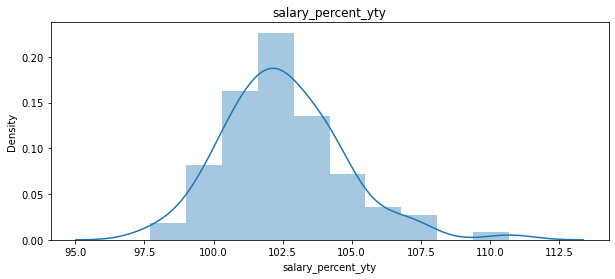

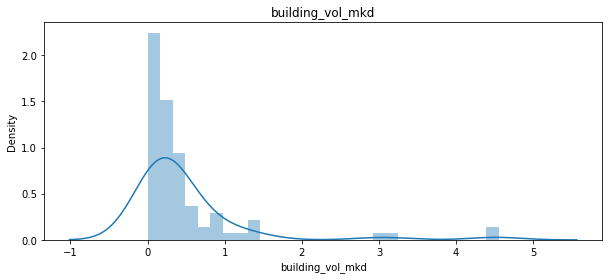

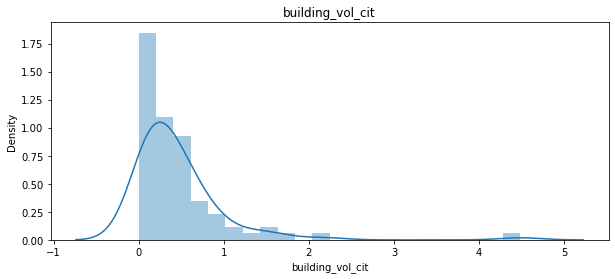

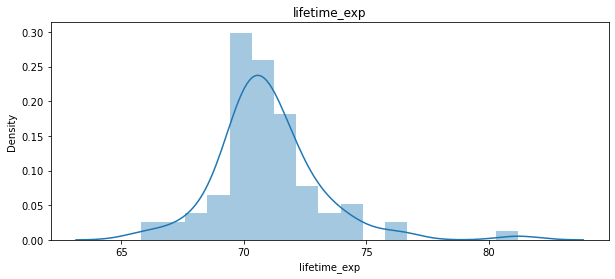

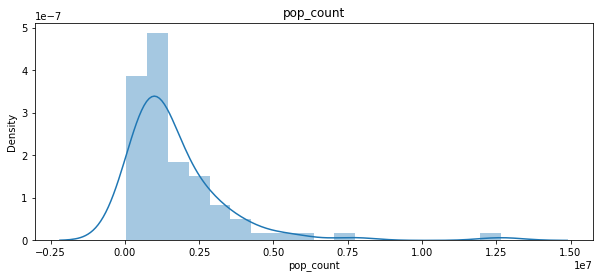

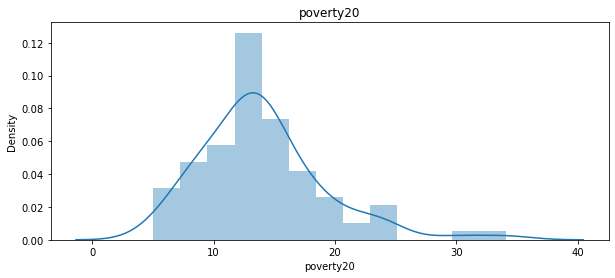

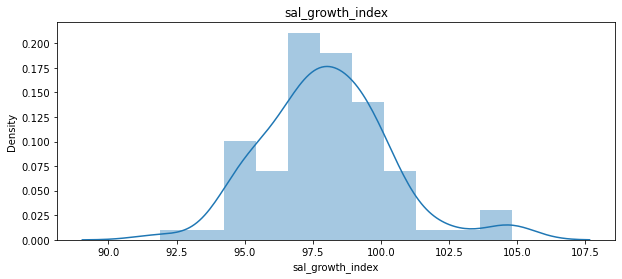

In [47]:
distplot_columns = ['salary_percent_yty', 'building_vol_mkd', 
                    'building_vol_cit', 'lifetime_exp', 
                    'pop_count', 'poverty20', 'sal_growth_index']
for column in distplot_columns: 
    plt.figure(figsize=(10,4)) 
    plt.title(column)
    sns.distplot(df[column])
#    plt.legend()
    plt.show()

**Реальная среднемесячная начисленная заработная плата работников организаций по субъектам Российской Федерации**:
- распределение больше других похоже на нормальное с наиболее часто встречаемым значением в 102,5%, при этом, как и на всех дальнейших графиках, есть небольшой всплеск ближе к краю правой ветки - видимо, за счет наиболее успешных регионов

**Темпы строительства МКД**:
- заметен сильный перекос графика влево, в большинстве регионов темп строительства МКД низкий

**Темпы строительства населением**:
- заметен сильный перекос графика влево, в большинстве регионов темп строительства населением низкий

**Ожидаемая продолжительность жизни**:
- средняя продолжительность жизни - чуть более 70 лет в среднем по РФ

**Население регионов**:
- большинство регионов имеют численность населения около 2 млн человек
- в целом, подавляющее число регионов - малонаселенные

**Уровень бедности**:
- в большинстве регионов уровень бедности находится в районе 13%
- тревожно то, что есть регионы с уровнем бедности более 30%

**Темп роста (индекс роста) реального среднедушевого денежного дохода**:
- в среднем, темп роста реального денежного дохода находится на уровне 97%, что предполагает падение реального уровня доходов населения
- регионов с уровнем более 100% (рост) меньшинство

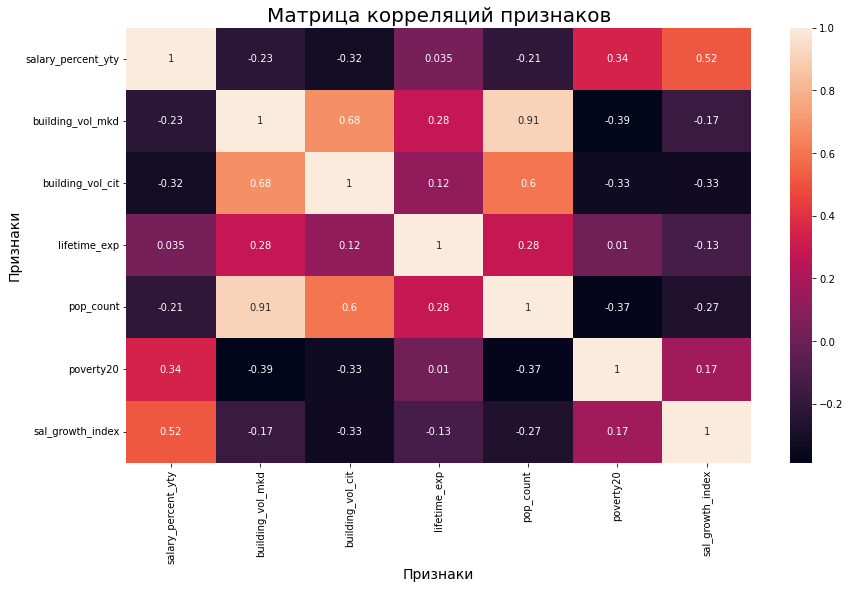

In [48]:
#матрица корреляций

matr = df.corr()
plt.figure(figsize=(14,8))
sns.heatmap(matr, annot = True, square=False)
plt.title('Матрица корреляций признаков', fontsize = 20)
plt.xlabel('Признаки', fontsize = 14)
plt.ylabel('Признаки', fontsize = 14)
plt.show()

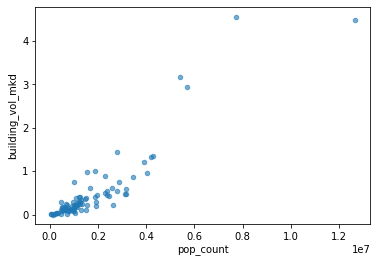

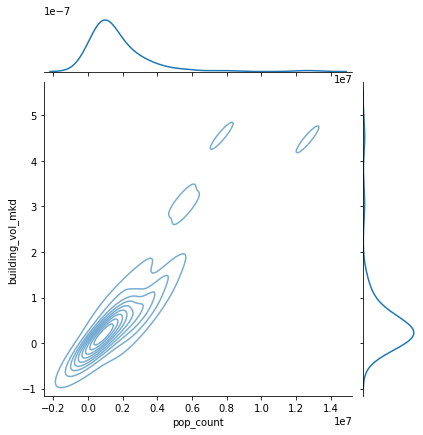

In [49]:
#диаграмма рассеяния

df.plot(x ='pop_count', y ='building_vol_mkd', kind ='scatter', alpha=0.6)

sns.jointplot(x="pop_count", y="building_vol_mkd", data=df, kind="kde", alpha = 0.6)

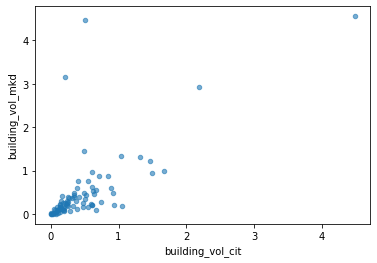

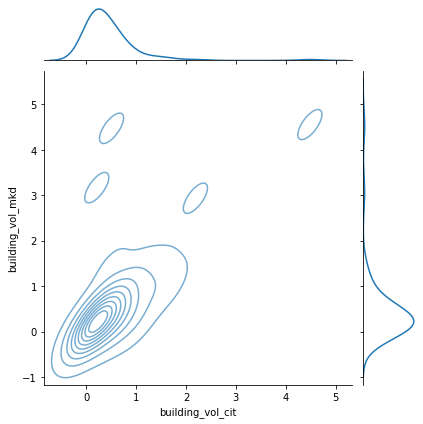

In [50]:
#диаграмма рассеяния

df.plot(x ='building_vol_cit', y ='building_vol_mkd', kind ='scatter', alpha=0.6)
sns.jointplot(x="building_vol_cit", y="building_vol_mkd", data=df, kind="kde", alpha = 0.6)

- Выявлена высокая (0,91) корреляций между численностью населения региона и объемами ввода жилья в МКД.
- Также высокая (0,68) корреляция между объемами ввода жилья в МКД и объемами ввода жилья, построенного населением.
- Интересное наблюдение: индекс роста зарплат имеет отрицательную коррекляцию с численностью населения региона (-0,27) и объемами ввода жилья, построенного населением (-0,32).

**Распределение данных:**
- всего записей в таблице 85 - данных может быть недостаточно для кластеризации
- пропусков и дубликатов нет, сильные выбросы отсутствуют
- все признаки являются числовыми

### Кластеризация регионов

In [51]:
#разделим данные на признаки (матрица X) 

X = df.drop('region', axis=1)

In [52]:
#стандартизируем данные 

sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc[:3]

array([[ 0.91389225, -0.34984331,  0.78589648,  0.65645833, -0.0991097 ,
        -1.32164214,  0.17063431],
       [-0.15149794, -0.30330453, -0.4931286 , -0.18614339, -0.2983163 ,
        -0.03285153, -0.95841307],
       [-0.05885531, -0.31079494,  0.02147783, -0.46701063, -0.20975257,
        -0.28670422,  0.04035961]])

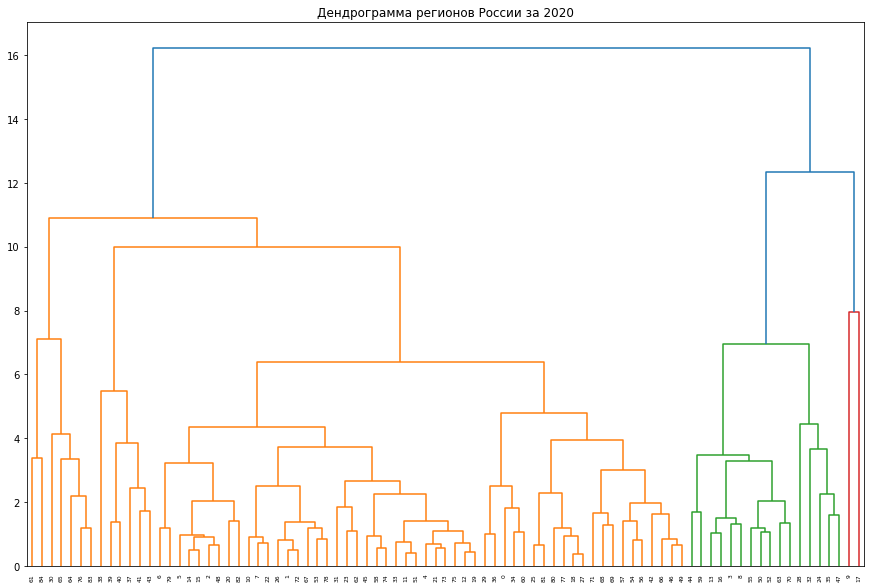

In [53]:
#матрица расстояний и дендрограмма 

linked = linkage(X_sc, method = 'ward')
linked 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма регионов России за 2020')
plt.show()

In [54]:
#обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
#число кластеров n=5

km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров
labels

array([2, 2, 2, 2, 2, 2, 2, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 1, 3, 2, 3, 2,
       3, 2, 2, 3, 2, 3, 1, 2, 0, 2, 1, 2, 3, 2, 2, 0, 0, 0, 0, 2, 3, 2,
       2, 3, 3, 2, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 3, 3,
       3, 2, 3, 3, 2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3])

In [55]:
# добавим столбец с номерами кластеров в первоначальный датафрейм

df['cluster_km'] = labels
display(df.head())

,region,salary_percent_yty,building_vol_mkd,building_vol_cit,lifetime_exp,pop_count,poverty20,sal_growth_index,cluster_km
2,Белгородская область,104.5,0.2136,0.9350,72.4,1541259,7.2,98.4,2
3,Брянская область,102.2,0.2515,0.1752,70.6,1182682,13.8,95.8,2
4,Владимирская область,102.4,0.2454,0.4809,70.0,1342099,12.5,98.1,2
5,Воронежская область,101.8,0.8812,0.8446,71.9,2305608,8.5,94.6,2
6,Ивановская область,100.6,0.1383,0.1949,70.7,987032,13.7,96.6,2


In [56]:
#сгруппируем датасет по кластерам

df.groupby(['cluster_km'])['region'].count()

cluster_km
0     5
1     3
2    48
3    28
4     1
Name: region, dtype: int64

In [57]:
#посчитаем метрику силуэта для кластеризации нашего датасета

print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.22


In [58]:
#изучим средние значения признаков для кластеров

df.drop('region', axis=1).groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
salary_percent_yty,1.061000e+02,1.013667e+02,1.014333e+02,103.996429,9.950000e+01
building_vol_mkd,1.468400e-01,3.524833e+00,4.482146e-01,0.178407,4.554400e+00
building_vol_cit,2.263000e-01,9.662667e-01,5.277958e-01,0.212204,4.485800e+00
lifetime_exp,7.594000e+01,7.413333e+01,7.098125e+01,69.782143,7.170000e+01
pop_count,1.050680e+06,7.907780e+06,1.729769e+06,944888.071429,7.708499e+06
poverty20,2.306000e+01,7.600000e+00,1.238333e+01,16.000000,6.800000e+00
sal_growth_index,9.868000e+01,9.850000e+01,9.688750e+01,99.846429,9.540000e+01


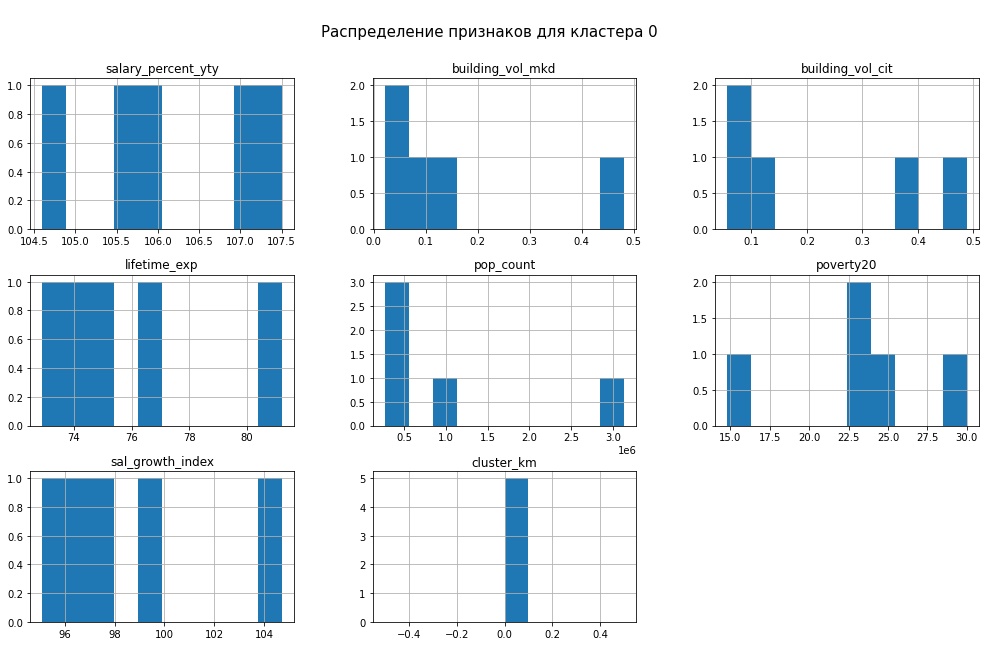

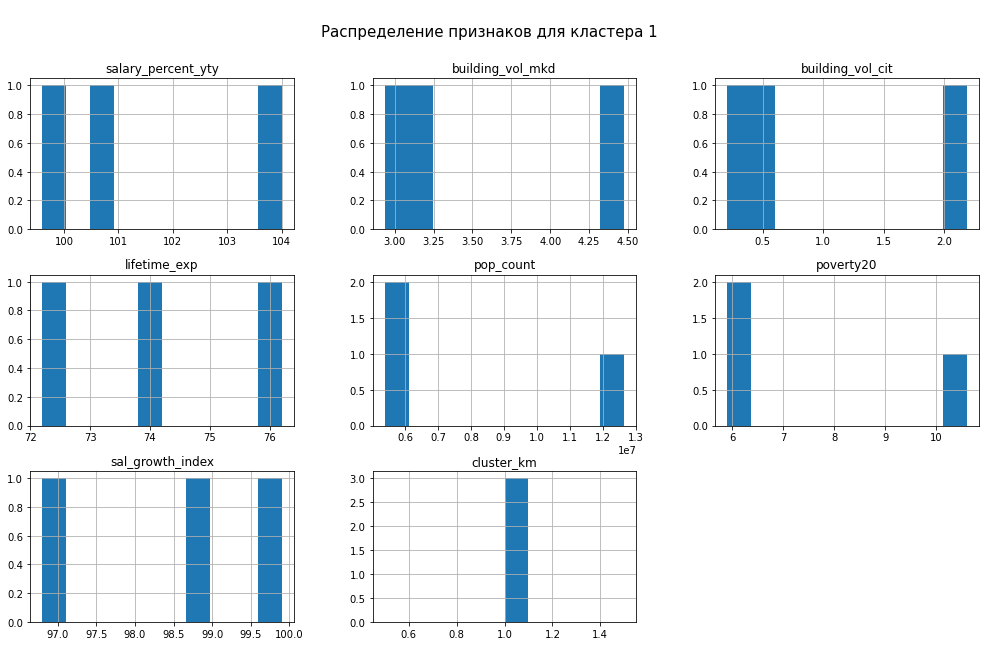

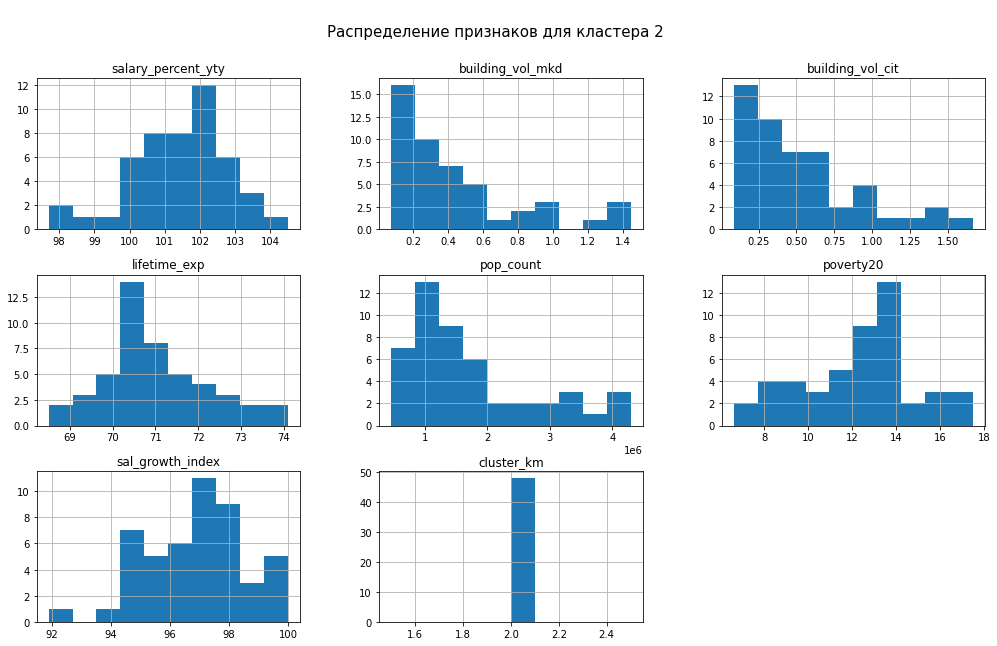

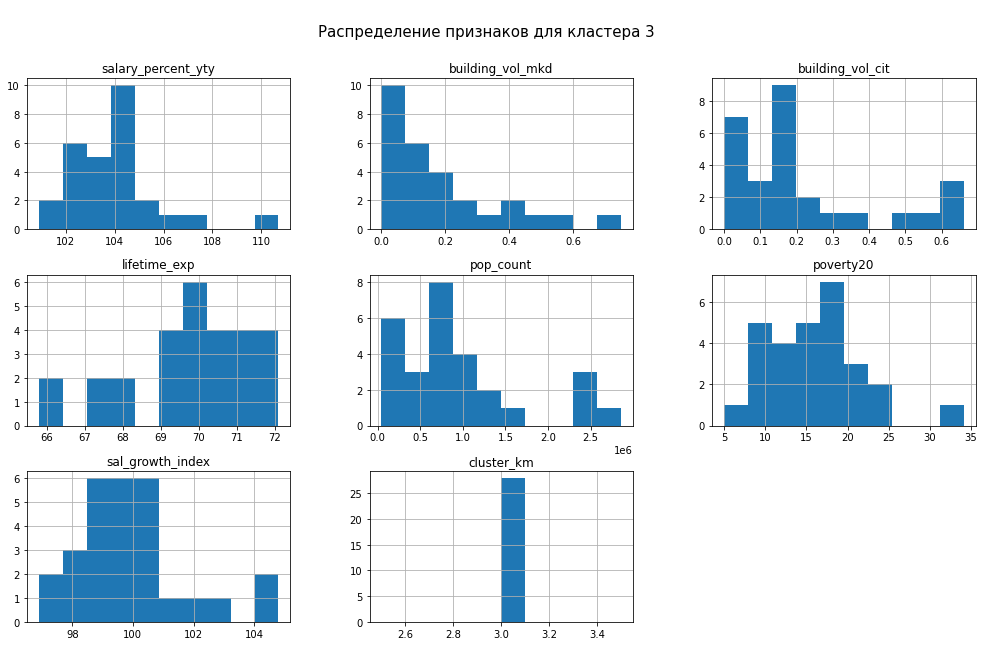

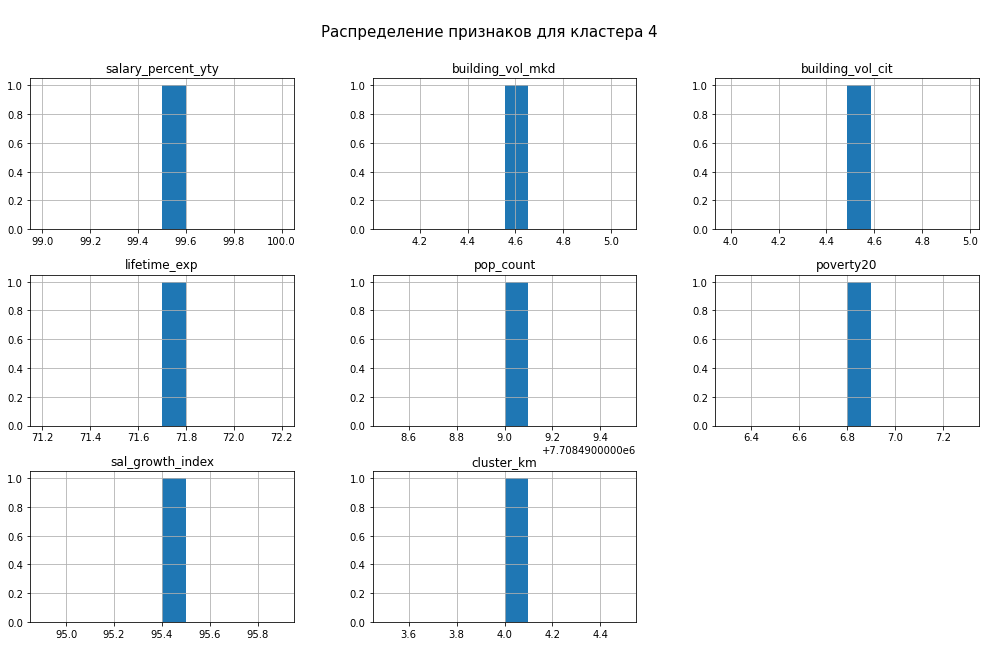

In [59]:
#построим распределение признаков для кластеров

for value in [0, 1, 2, 3, 4]:
    df[df['cluster_km'] == value].hist(figsize=(17,10))
    plt.suptitle('\nРаспределение признаков для кластера {}'.format(value), fontsize = 15)
    plt.show()

**Характеристики кластера 0:**
- разброс роста зарплат год к году от 105 до 107%
- темп строительства жилья МКД от 0 до 0.3
- тем строительства жилья населением от 0 до 0.5
- ожидаемая продолжительность жизни - 74-76 лет
- население региона - от 0.5 до 3 млн
- уровень бедности высокий, более 22%
- индекс роста зарплат менее 100%

**Характеристики кластера 1:**
- разброс роста зарплат год к году от 100 до 104%
- темп строительства жилья МКД от 3 до 4.5
- тем строительства жилья населением от 0 до 2
- ожидаемая продолжительность жизни - 72-76 лет
- население региона - от 5 до 12 млн
- уровень бедности от 6% до 11%
- индекс роста зарплат от 97% до 100%

**Характеристики кластера 2:**
- разброс роста зарплат год к году от 100 до 110%
- темп строительства жилья МКД от 0 до 0.7
- тем строительства жилья населением от 0 до 0.7
- ожидаемая продолжительность жизни - 72 года
- население региона - до 4 млн
- уровень бедности от 5% до 30%
- индекс роста зарплат в основном, менее 100%

**Характеристики кластера 3:**
- разброс роста зарплат год к году от 100 до 104%
- темп строительства жилья МКД от 0 до 1.4
- тем строительства жилья населением от 0 до 1.5
- ожидаемая продолжительность жизни - в основном, в районе 71 года
- население региона - от 1 до 2.5 млн
- уровень бедности от 4% до 18%
- индекс роста зарплат от 92% до 100%

**Характеристики кластера 4:**
- разброс роста зарплат год к году 99.5%
- темп строительства жилья МКД 4.6
- тем строительства жилья населением 4.5
- ожидаемая продолжительность жизни - в основном, в районе 71 года
- население региона - 9 млн
- уровень бедности 6.8%
- индекс роста зарплат от 95.4%

In [60]:
#список регионов в кластере 0

cluster0_regions = df[df['cluster_km'] == 0]['region'].to_list()
cluster0_regions

['Республика Калмыкия',
 'Республика Дагестан',
 'Республика Ингушетия',
 'Кабардино-Балкарская Республика',
 'Карачаево-Черкесская Республика']

In [61]:
#список регионов в кластере 1

cluster1_regions = df[df['cluster_km'] == 1]['region'].to_list()
cluster1_regions

['г. Москва', 'г.Санкт-Петербург', 'Краснодарский край']

In [62]:
#список регионов в кластере 2

cluster2_regions = df[df['cluster_km'] == 2]['region'].to_list()
cluster2_regions

['Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Воронежская область',
 'Ивановская область',
 'Калужская область',
 'Костромская область',
 'Липецкая область',
 'Рязанская область',
 'Смоленская область',
 'Тамбовская область',
 'Тверская область',
 'Тульская область',
 'Ярославская область',
 'Республика Коми',
 'Архангельская область (кроме Ненецкого автономного округа)',
 'Калининградская область',
 'Ленинградская область',
 'Новгородская область',
 'Республика Адыгея',
 'Республика Крым',
 'Астраханская область',
 'Ростовская область',
 'г.Севастополь',
 'Республика Северная Осетия - Алания',
 'Ставропольский край',
 'Республика Башкортостан',
 'Республика Татарстан',
 'Удмуртская Республика',
 'Пермский край',
 'Кировская область',
 'Hижегородская область',
 'Оренбургская область',
 'Самарская область',
 'Ульяновская область',
 'Свердловская область',
 'Ханты-Мансийский авт.округ - Югра',
 'Тюменская область (кроме Ханты-Мансийского автономного округа - Юг

In [63]:
#список регионов в кластере 3

cluster3_regions = df[df['cluster_km'] == 3]['region'].to_list()
cluster3_regions

['Курская область',
 'Орловская область',
 'Республика Карелия',
 'Hенецкий авт.округ',
 'Вологодская область',
 'Мурманская область',
 'Псковская область',
 'Волгоградская область',
 'Чеченская Республика',
 'Республика Марий Эл',
 'Республика Мордовия',
 'Чувашская Республика',
 'Пензенская область',
 'Саратовская область',
 'Курганская область',
 'Ямало-Hенецкий авт.округ',
 'Республика Алтай',
 'Республика Тыва',
 'Республика Хакасия',
 'Красноярский край',
 'Иркутская область',
 'Республика Бурятия',
 'Забайкальский край',
 'Камчатский край',
 'Амурская область',
 'Магаданская область',
 'Еврейская авт.область',
 'Чукотский авт.округ']

In [64]:
#список регионов в кластере 4

cluster4_regions = df[df['cluster_km'] == 4]['region'].to_list()
cluster4_regions

['Московская область']

## Список территорий и алгоритм увольнения губернаторов и критерии и правила увольнений

**Предлагаемая методика оценки эффективности управления регионом**
- Выберем 4 ключевые параметра оценки эффективности управления регионом
- По каждому критерию выберем регионы, находящиеся во второй половине списка (ниже медианы)
- Найдем пересечения всех 4 списков, таким образом обнаружим регионы, отстающие по всем ключевым показателям эффективности

**Критерии и правила увольнения губернаторов**
- Губернатор находится в зоне риска в том случае, если регион под его управлением находится в списке пересечений списков неэффективных регионов
- Дать задание губернатору объяснить низкие показатели управления своим регионом (возможно, регион участвует в реализации крупного долгосрочного нацпроекта, и результаты управления регионом в дальнейшем будут улучшаться, но на более длительном горизонте планирования), попросить предоставить план реализации долгосрочных инвестпроектов, имеющих влияние на эффективность управления регионом
- Уточнить прочие показатели эффективност управления регионом, которые делают управление им уникальным (анклав, особые климатические или логистические условия)
- В случае, если регион попал в список пересечений списков неэффективных регионов, крупные нацпроекты не запланированы к реализации в подотчетном регионе, а прочие показатели эффективности управления не имеют существенной значимости, уволить губернатора.

In [65]:
#предварительно сложим значения ввода жилья и далее рассмотрим суммарное значение

df['building_vol'] = df['building_vol_mkd'] + df['building_vol_cit']

#выберем регионы, которые по каждому из критериев показывает результаты во второй половине списка, 
#при этому сосредоточимся на индексе роста реальных зарплат, уровне бедности, ожидаемой продолжительности жизни, 
#а так же на суммарных объемах ввода жилья 

low_building_vol = df[df['building_vol'] < df.building_vol.quantile(0.5)]['region'].to_list()
low_lifetime_exp = df[df['lifetime_exp'] < df.lifetime_exp.quantile(0.5)]['region'].to_list()
high_poverty20 = df[df['poverty20'] > df.poverty20.quantile(0.5)]['region'].to_list()
low_sal_growth_index = df[df['sal_growth_index'] < df.sal_growth_index.quantile(0.5)]['region'].to_list()

In [66]:
#найдем регионы, которые попали в каждый из непочетных списков отстающих

d = [low_building_vol, high_poverty20, low_lifetime_exp, low_sal_growth_index]  
list(reduce(set.intersection, [set(item) for item in d ]))

['Омская область',
 'Смоленская область',
 'Брянская область',
 'Республика Коми',
 'Новгородская область',
 'Республика Бурятия',
 'Курганская область']

**Выше представлен список неэффективно управляемых регионов, губернаторам которых следует подготовить дополнительные данные согласно методологии, представленной ранее**

## Вывод

**Качество данных:**
- данные предоставлены в полном объеме, без пропусков и дубликатов
- есть замечания к формату записи названий регионов - он он отличается от документа к документу

**Исследовательский анализ данных:**
- данные распределены неравномерно, стандартные отклонения сильно расходятся со средними значениями
- реальная среднемесячная начисленная заработная плата работников имеет распределение больше других похоже на нормальное с наиболее часто встречаемым значением в 102,5%, при этом, как и на всех дальнейших графиках, есть небольшой всплеск ближе к краю правой ветки - видимо, за счет наиболее успешных регионов
- темпы строительства МКД: заметен сильный перекос графика влево, в большинстве регионов темп строительства МКД низкий
- темпы строительства населением: заметен сильный перекос графика влево, в большинстве регионов темп строительства населением низкий
- средняя продолжительность жизни - чуть более 70 лет в среднем по РФ
- большинство регионов имеют численность населения около 2 млн человек
- в целом, подавляющее число регионов - малонаселенные
- в большинстве регионов уровень бедности находится в районе 13%
- тревожно то, что есть регионы с уровнем бедности более 30%
- в среднем, темп роста реального денежного дохода находится на уровне 97%, что предполагает падение реального уровня доходов населения
- регионов с уровнем более 100% (рост) меньшинство

**Корреляция ризнаков:**
- выявлена высокая (0.91) корреляций между численностью населения региона и объемами ввода жилья в МКД
- также высокая (0.68) корреляция между объемами ввода жилья в МКД и объемами ввода жилья, построенного населением
- индекс роста зарплат имеет отрицательную коррекляцию с численностью населения региона (-0.27) и объемами ввода жилья, построенного населением (-0.32)

**Кластерный анализ:**
Каждый регион России в самом общем случае можно рассматривать как сложную систему управления, подчиняющуюся действиям как внешних условий, так и внутренних факторов развития. Несмотря на особенности регионов, есть и много схожих процессов, свойственных ряду регионов. Одним из методов, позволяющих провести исследование процессов регионального развития, является кластерный анализ. Применение методов кластерного анализа позволяет на основе статистических данных по различным показателям социально-экономического развития регионов объединить отдельные регионы в целевые кластеры. Анализ таких кластеров позволяет выявлять и эффективно решать типичные проблемы регионального развития, придать ускорение экономическим процессам, сконцентрировать ресурсы на ключевых направлениях.

**Целью исследования** является выделение групп регионов со схожими социально-экономическими показателями.

Для решения задач кластеризации с небольшим числом факторных признаков использована **иерархическая кластеризация**.

**Метод:** использован метод K-Means (метод K-средних).

В ходе кластеризации массив данных разбили на 5 кластеров. Кластеризация прошла неточно (Silhouette_score: 0.22): есть перекрывающиеся кластеры. 

**Число кластеров:** в ходе анализа дендрограммы принято решение разбить регионы на 5 кластеров.

**Характеристики кластера 0:**
- регионы: Республика Калмыкия, Республика Дагестан, Республика Ингушетия, Кабардино-Балкарская Республика, Карачаево-Черкесская Республика
- разброс роста зарплат год к году от 105 до 107%
- темп строительства жилья МКД от 0 до 0.3
- тем строительства жилья населением от 0 до 0.5
- ожидаемая продолжительность жизни - 74-76 лет
- население региона - от 0.5 до 3 млн
- уровень бедности высокий, более 22%
- индекс роста зарплат менее 100%

*Вывод по кластеру 0: в целом, депрессивные и малочисленные национальные республики, требующие повышенного внимания для обеспечения устойчивого роста* 

**Характеристики кластера 1:**
- регионы: г. Москва, г.Санкт-Петербург, Краснодарский край
- разброс роста зарплат год к году от 100 до 104%
- темп строительства жилья МКД от 3 до 4.5
- тем строительства жилья населением от 0 до 2
- ожидаемая продолжительность жизни - 72-76 лет
- население региона - от 5 до 12 млн
- уровень бедности от 6% до 11%
- индекс роста зарплат от 97% до 100%

*Вывод по кластеру 1: густонаселенные регионы с низким относительно других регионов уровнем бедности* 

**Характеристики кластера 2:**
- регионы: Белгородская область, Брянская область, Владимирская область, Воронежская область, Ивановская область, Калужская область, Костромская область, Липецкая область, Рязанская область, Смоленская область, Тамбовская область, Тверская область, Тульская область, Ярославская область, Республика Коми, Архангельская область (кроме Ненецкого автономного округа), Калининградская область, Ленинградская область, Новгородская область, Республика Адыгея, Республика Крым, Астраханская область, Ростовская область, г.Севастополь, Республика Северная Осетия - Алания, Ставропольский край, Республика Башкортостан, Республика Татарстан, Удмуртская Республика, Пермский край, Кировская область, Hижегородская область, Оренбургская область, Самарская область, Ульяновская область, Свердловская область, Ханты-Мансийский авт.округ - Югра, Тюменская область (кроме Ханты-Мансийского автономного округа - Югры и Ямало-Ненецкого автономного округа), Челябинская область, Алтайский край, Кемеровская область - Кузбасс, Новосибирская область, Омская область, Томская область, Республика Саха (Якутия), Приморский край, Хабаровский край, Сахалинская область
- разброс роста зарплат год к году от 100 до 110%
- темп строительства жилья МКД от 0 до 0.7
- тем строительства жилья населением от 0 до 0.7
- ожидаемая продолжительность жизни - 72 года
- население региона - до 4 млн
- уровень бедности от 5% до 30%
- индекс роста зарплат в основном, менее 100%

*Вывод по кластеру 2: разношерстная группа регионов, объединенных по формальному признаку* 

**Характеристики кластера 3:**
- регионы: Курская область, Орловская область, Республика Карелия, Hенецкий авт.округ, Вологодская область, Мурманская область, Псковская область, Волгоградская область, Чеченская Республика, Республика Марий Эл, Республика Мордовия, Чувашская Республика, Пензенская область, Саратовская область, Курганская область, Ямало-Hенецкий авт.округ, Республика Алтай, Республика Тыва, Республика Хакасия, Красноярский край, Иркутская область, Республика Бурятия, Забайкальский край, Камчатский край, Амурская область, Магаданская область, Еврейская авт.область, Чукотский авт.округ
- разброс роста зарплат год к году от 100 до 104%
- темп строительства жилья МКД от 0 до 1.4
- тем строительства жилья населением от 0 до 1.5
- ожидаемая продолжительность жизни - в основном, в районе 71 года
- население региона - от 1 до 2.5 млн
- уровень бедности от 4% до 18%
- индекс роста зарплат от 92% до 100%

*Вывод по кластеру 3: разношерстная группа регионов, сопоставимая по успешности с кластером 2* 

**Характеристики кластера 4:**
- регион: Москвоская область
- разброс роста зарплат год к году 99.5%
- темп строительства жилья МКД 4.6
- тем строительства жилья населением 4.5
- ожидаемая продолжительность жизни - в основном, в районе 71 года
- население региона - 9 млн
- уровень бедности 6.8%
- индекс роста зарплат от 95.4%

*Вывод по кластеру 4: кластер представлен единственным регионом, находящимся по уровню эффективности между успешным кластером 1 и стагнирующими 2 и 3. Кластер отличает высокое число населения и очень высокие темпы строительства* 

**Алгоритм увольнения губернаторов и критерии и правила увольнений**
- предложен алгоритм поиска отстающих регионов на основании укрупненных метрик и списка пересечения списков отстающих регионов (назовем его СПСОР)
- выявлен список отстающих одновременно по всем направлениям регионов: Брянская область, Смоленская область, Новгородская область, Республика Коми, Республика Бурятия, Курганская область, Омская область.